# E1: Domain Adaptation Extension

**Research Question:** Does the AskQE metric maintain its performance and stability when transitioned from medical and covid domain to a highly technical legal domain?

### **Overview**
This extension explores the behavior of AskQE using a specialized legal dataset. While the original framework was tested on informative/narrative corpora (like Wikipedia), legal texts present unique challenges: high lexical overlap, rigid terminology, and complex conditional logic (e.g., "unless otherwise provided").<br><br>

### **Dataset Source & Generation**
The evaluation is conducted on the **OPUS-DGT** corpus, which contains official documents of the Directorate-General for Translation of the European Commission.

* **Source Reference:** > Jorg Tiedemann. "Parallel Data, Tools and Interfaces in OPUS." In Proceedings of the Eighth International Conference on Language Resources and Evaluation (LREC'12), Istanbul, Turkey, 2012.<br>

**NOTE**: This notebook has hardcoded paths for COLAB.




## 0. Setup

In [1]:
!git clone -b domain-adaptation-ext https://github.com/AlessandroMaini/CucumBERT_askqe.git

Cloning into 'CucumBERT_askqe'...
remote: Enumerating objects: 2630, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 2630 (delta 85), reused 116 (delta 66), pack-reused 2484 (from 2)
Receiving objects: 100% (2630/2630), 67.26 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (1828/1828), done.


In [4]:
!pip install -q -r /content/CucumBERT_askqe/notebooks/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 31.1 MB/s eta 0:00:00


## 1. Legal Domain Analytics

We focus on understanding the main features of the new legal dataset, throught useful insights.

In [6]:
import json
import os
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import random
import string

# Download necessary NLTK data (if not already downloaded)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

def load_data(filepath):
    """Loads data from a .jsonl file."""
    data = []
    if not os.path.exists(filepath):
        print(f"Warning: File not found at {filepath}")
        return data
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from line: {line.strip()} - {e}")
    return data

def analyze_text_field(texts, field_name):
    """Analyzes a list of texts for word/token counts and sentence counts."""
    total_words = 0  # Words without punctuation
    total_tokens = 0 # Tokens including punctuation
    total_sentences = 0
    total_entries = len(texts)

    if not texts: # Handle empty list
        return {
            'average_words_per_entry': 0,
            'average_tokens_per_entry': 0,
            'average_sentences_per_entry': 0,
            'total_entries': 0
        }

    for text in texts:
        sentences = sent_tokenize(text)
        total_sentences += len(sentences)
        for sentence in sentences:
            # Tokenize the sentence
            tokens_in_sentence = word_tokenize(sentence)
            total_tokens += len(tokens_in_sentence)

            # Count words by filtering out punctuation from tokens
            words_in_sentence = [token for token in tokens_in_sentence if token not in string.punctuation]
            total_words += len(words_in_sentence)

    avg_words_per_entry = total_words / total_entries
    avg_tokens_per_entry = total_tokens / total_entries
    avg_sentences_per_entry = total_sentences / total_entries

    return {
        'average_words_per_entry': avg_words_per_entry,
        'average_tokens_per_entry': avg_tokens_per_entry,
        'average_sentences_per_entry': avg_sentences_per_entry,
        'total_entries': total_entries
    }

def print_random_samples(data, num_samples=3):
    """Prints random samples from the dataset."""
    if not data:
        print("No data available for sampling.")
        return

    print(f"\n--- Random Samples ({min(num_samples, len(data))} of {len(data)}) ---")
    samples = random.sample(data, min(num_samples, len(data)))
    for i, entry in enumerate(samples):
        print(f"\nSample {i+1}:")
        for key, value in entry.items():
            print(f"  {key}: {value}")


# Dataset paths
dataset_paths = {
    "en-es": "/content/CucumBERT_askqe/data/processed/en-es.jsonl",
    "en-fr": "/content/CucumBERT_askqe/data/processed/en-fr.jsonl"
}

print("### Dataset Insights ###")

for name, path in dataset_paths.items():
    print(f"\nAnalyzing dataset: {name} ({path})")
    dataset = load_data(path)

    if not dataset:
        print(f"No data loaded for {name}. Skipping analysis.")
        continue

    src_lang = name.split('-')[0]
    target_lang = name.split('-')[1]

    original_texts = [entry[src_lang] for entry in dataset if src_lang in entry]
    mt_texts = [entry[target_lang] for entry in dataset if target_lang in entry]

    print("\n--- Original Text Statistics (English) ---")
    stats_original = analyze_text_field(original_texts, 'original_text')
    print(f"Total entries: {stats_original['total_entries']}")
    print(f"Average words per original entry: {stats_original['average_words_per_entry']:.2f}")
    print(f"Average tokens per original entry: {stats_original['average_tokens_per_entry']:.2f}")
    print(f"Average sentences per original entry: {stats_original['average_sentences_per_entry']:.2f}")

    print("\n--- Translation Statistics ---")
    stats_mt = analyze_text_field(mt_texts, 'machine_translation')
    print(f"Total entries: {stats_mt['total_entries']}")
    print(f"Average words per MT entry: {stats_mt['average_words_per_entry']:.2f}")
    print(f"Average tokens per MT entry: {stats_mt['average_tokens_per_entry']:.2f}")
    print(f"Average sentences per MT entry: {stats_mt['average_sentences_per_entry']:.2f}")

    # Print random samples
    print_random_samples(dataset, num_samples=3)

print("\n### Analysis Complete ###")

### Dataset Insights ###

Analyzing dataset: en-es (/content/CucumBERT_askqe/data/processed/en-es.jsonl)

--- Original Text Statistics (English) ---
Total entries: 500
Average words per original entry: 22.75
Average tokens per original entry: 25.12
Average sentences per original entry: 1.00

--- Translation Statistics ---
Total entries: 500
Average words per MT entry: 25.80
Average tokens per MT entry: 28.08
Average sentences per MT entry: 1.03

--- Random Samples (3 of 500) ---

Sample 1:
  id: 144
  en: In the same circumstances, any present Member State may apply for authorisation to take protective measures with regard to Bulgaria, Romania, or both those States.
  es: En las mismas circunstancias, cualquier Estado miembro actual podrá pedir autorización para adoptar medidas de salvaguardia respecto de Bulgaria, de Rumanía, o de ambos Estados.

Sample 2:
  id: 358
  en: the aid measures shall be communicated to the Commission within four months of the date of accession.
  es: las me

## 2. Extension Evaluation (E1 - Domain Adaptation)

### 2.0 Question Generation Analysis

This analysis compares the **vanilla** and **atomic** question generation pipelines across the legal domain dataset. The goals are:

1. **Quantify question generation diversity**: Measure how many questions each pipeline generates per entry on average
2. **Analyze fact-to-question mapping**: Understand the relationship between atomic facts and generated questions in the atomic pipeline
3. **Evaluate fact extraction quality**: Compare atomic facts with entailed facts (filtered for logical consistency)


The resulting visualizations help understand whether the atomic pipeline's decomposition strategy leads to more controlled, fact-grounded question generation compared to vanilla's more exploratory approach.


QUESTION GENERATION ANALYSIS — Pipeline Comparison

🔴 VANILLA Pipeline Questions:
   • Total entries: 500
   • Average questions per entry: 4.30
   • Min/Max: 1/8
   • Total questions: 2149

🔴 ATOMIC Pipeline Questions:
   • Total entries: 500
   • Average questions per entry: 2.00
   • Min/Max: 1/9
   • Total questions: 1000

🔵ATOMIC Facts (from atomic_facts.jsonl):
   • Total entries: 500
   • Average facts per entry: 2.42
   • Min/Max: 1/19
   • Total facts: 1209

🔵 ENTAILED Facts (from entailed_facts.jsonl):
   • Total entries: 500
   • Average entailed facts per entry: 2.31
   • Min/Max: 0/19
   • Total entailed facts: 1157

KEY INSIGHTS:
   • Atomic generates 0.47x more questions than Vanilla
   • Average facts-to-questions ratio: 1.21
   • Entailed facts are 0.96x more than atomic facts



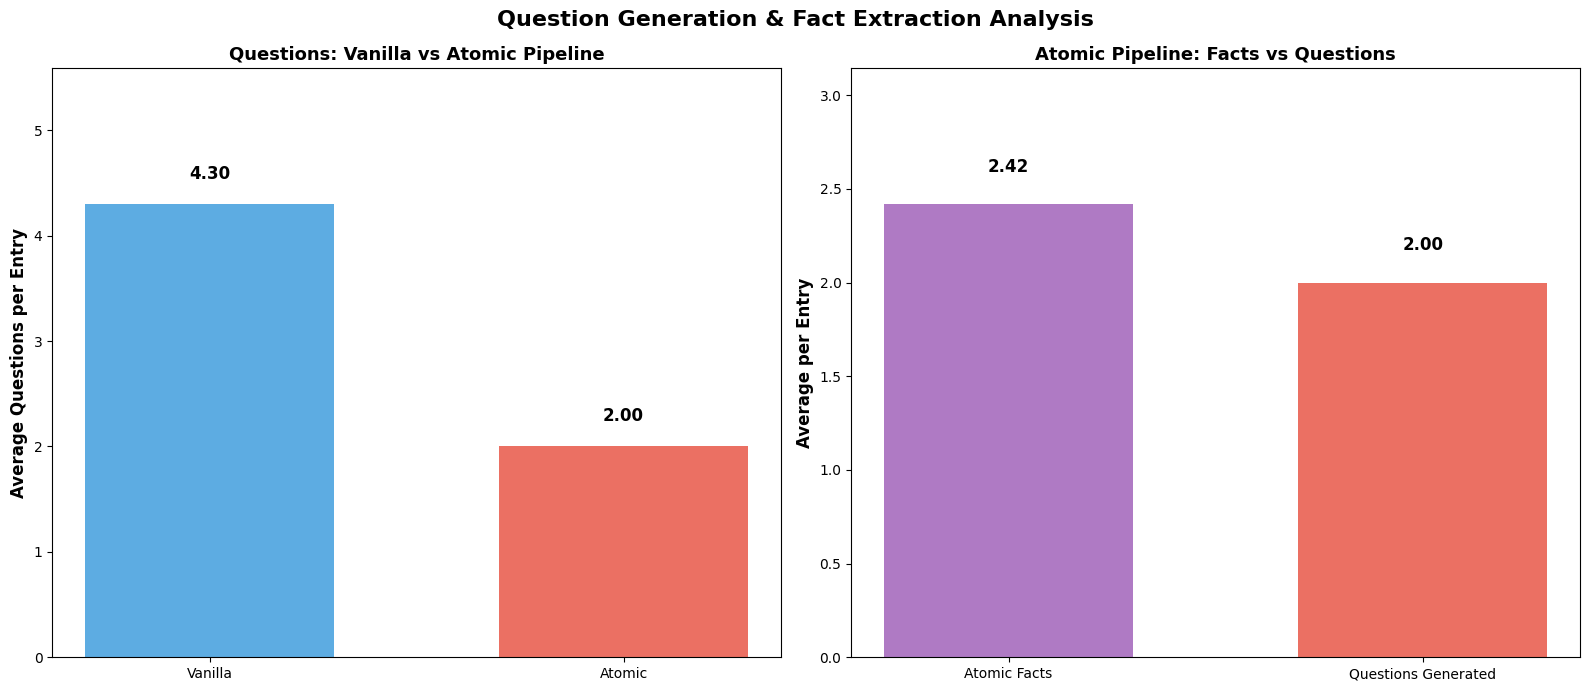

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt

def load_jsonl(filepath):
    """Load JSONL file into list of dictionaries"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

def parse_questions(questions_field):
    """Parse questions field (handle both list and JSON string formats)"""
    if isinstance(questions_field, str):
        try:
            return json.loads(questions_field)
        except:
            return []
    return questions_field if isinstance(questions_field, list) else []

def parse_facts(facts_field):
    """Parse facts field (handle both list and JSON string formats)"""
    if isinstance(facts_field, str):
        try:
            return json.loads(facts_field)
        except:
            return []
    return facts_field if isinstance(facts_field, list) else []

# Load all QG data
vanilla_questions = load_jsonl('/content/CucumBERT_askqe/QG/qwen3-4b/questions-vanilla.jsonl')
atomic_questions = load_jsonl('/content/CucumBERT_askqe/QG/qwen3-4b/questions-atomic.jsonl')
atomic_facts_data = load_jsonl('/content/CucumBERT_askqe/QG/atomic_facts.jsonl')
entailed_facts_data = load_jsonl('/content/CucumBERT_askqe/QG/entailed_facts.jsonl')

print("\n" + "="*70)
print("QUESTION GENERATION ANALYSIS — Pipeline Comparison")
print("="*70)

# Analyze questions
vanilla_q_counts = [len(parse_questions(entry.get('questions', []))) for entry in vanilla_questions]
atomic_q_counts = [len(parse_questions(entry.get('questions', []))) for entry in atomic_questions]

avg_vanilla_q = sum(vanilla_q_counts) / len(vanilla_q_counts) if vanilla_q_counts else 0
avg_atomic_q = sum(atomic_q_counts) / len(atomic_q_counts) if atomic_q_counts else 0

print("\n🔴 VANILLA Pipeline Questions:")
print(f"   • Total entries: {len(vanilla_questions)}")
print(f"   • Average questions per entry: {avg_vanilla_q:.2f}")
print(f"   • Min/Max: {min(vanilla_q_counts)}/{max(vanilla_q_counts)}")
print(f"   • Total questions: {sum(vanilla_q_counts)}")

print("\n🔴 ATOMIC Pipeline Questions:")
print(f"   • Total entries: {len(atomic_questions)}")
print(f"   • Average questions per entry: {avg_atomic_q:.2f}")
print(f"   • Min/Max: {min(atomic_q_counts)}/{max(atomic_q_counts)}")
print(f"   • Total questions: {sum(atomic_q_counts)}")

atomic_facts_counts = [len(parse_facts(entry.get('atomic_facts', []))) for entry in atomic_facts_data]
avg_atomic_facts = sum(atomic_facts_counts) / len(atomic_facts_counts) if atomic_facts_counts else 0

print("\n🔵ATOMIC Facts (from atomic_facts.jsonl):")
print(f"   • Total entries: {len(atomic_facts_data)}")
print(f"   • Average facts per entry: {avg_atomic_facts:.2f}")
print(f"   • Min/Max: {min(atomic_facts_counts)}/{max(atomic_facts_counts)}")
print(f"   • Total facts: {sum(atomic_facts_counts)}")

entailed_facts_counts = [len(parse_facts(entry.get('atomic_facts', []))) for entry in entailed_facts_data]
avg_entailed_facts = sum(entailed_facts_counts) / len(entailed_facts_counts) if entailed_facts_counts else 0

print("\n🔵 ENTAILED Facts (from entailed_facts.jsonl):")
print(f"   • Total entries: {len(entailed_facts_data)}")
print(f"   • Average entailed facts per entry: {avg_entailed_facts:.2f}")
print(f"   • Min/Max: {min(entailed_facts_counts)}/{max(entailed_facts_counts)}")
print(f"   • Total entailed facts: {sum(entailed_facts_counts)}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print(f"   • Atomic generates {avg_atomic_q/avg_vanilla_q:.2f}x more questions than Vanilla")
print(f"   • Average facts-to-questions ratio: {avg_atomic_facts/avg_atomic_q:.2f}")
print(f"   • Entailed facts are {avg_entailed_facts/avg_atomic_facts:.2f}x more than atomic facts")
print("="*70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Question Generation & Fact Extraction Analysis', fontsize=16, fontweight='bold')

# Chart 1: Questions comparison (Vanilla vs Atomic)
ax1 = axes[0]
pipelines = ['Vanilla', 'Atomic']
q_avgs = [avg_vanilla_q, avg_atomic_q]
colors = ['#3498db', '#e74c3c']
bars1 = ax1.bar(pipelines, q_avgs, color=colors, alpha=0.8, width=0.6)
ax1.set_ylabel('Average Questions per Entry', fontsize=12, fontweight='bold')
ax1.set_title('Questions: Vanilla vs Atomic Pipeline', fontsize=13, fontweight='bold')
ax1.set_ylim(0, max(q_avgs) * 1.3)
for bar, val in zip(bars1, q_avgs):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.2f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Chart 2: Facts vs Questions in Atomic Pipeline
ax2 = axes[1]
categories = ['Atomic Facts', 'Questions Generated']
values = [avg_atomic_facts, avg_atomic_q]
colors_atomic = ['#9b59b6', '#e74c3c']
bars2 = ax2.bar(categories, values, color=colors_atomic, alpha=0.8, width=0.6)
ax2.set_ylabel('Average per Entry', fontsize=12, fontweight='bold')
ax2.set_title('Atomic Pipeline: Facts vs Questions', fontsize=13, fontweight='bold')
ax2.set_ylim(0, max(values) * 1.3)
for bar, val in zip(bars2, values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.15, f'{val:.2f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 2.1 String Comparison Analysis

**String-based metrics** evaluate translation quality by comparing the generated anwsers against reference answers through surface-level similarity:

- **F1 Score**: Harmonic mean of precision and recall at token level — balances completeness and accuracy
- **BLEU**: Measures n-gram overlap between candidate and reference — sensitive to word order
- **chrF**: Character-level F-score — more robust to morphological variations

**Key Question**: How do vanilla and atomic pipelines perform across different perturbation types? This reveals pipeline robustness to translation errors.

Loaded average scores from string-comparison data:
Perturbation  Vanilla_F1  Vanilla_chrF  Vanilla_BLEU  Atomic_F1  Atomic_chrF  Atomic_BLEU
  Alteration    0.573175     60.106378     42.781210   0.535772    54.907954    38.449915
     Synonym    0.661328     67.337323     50.057557   0.712836    70.556120    53.365109
   Expansion    0.678474     69.926752     49.099789   0.695854    69.630039    49.491181
    Omission    0.604835     62.068923     44.458637   0.629320    64.124901    45.410419


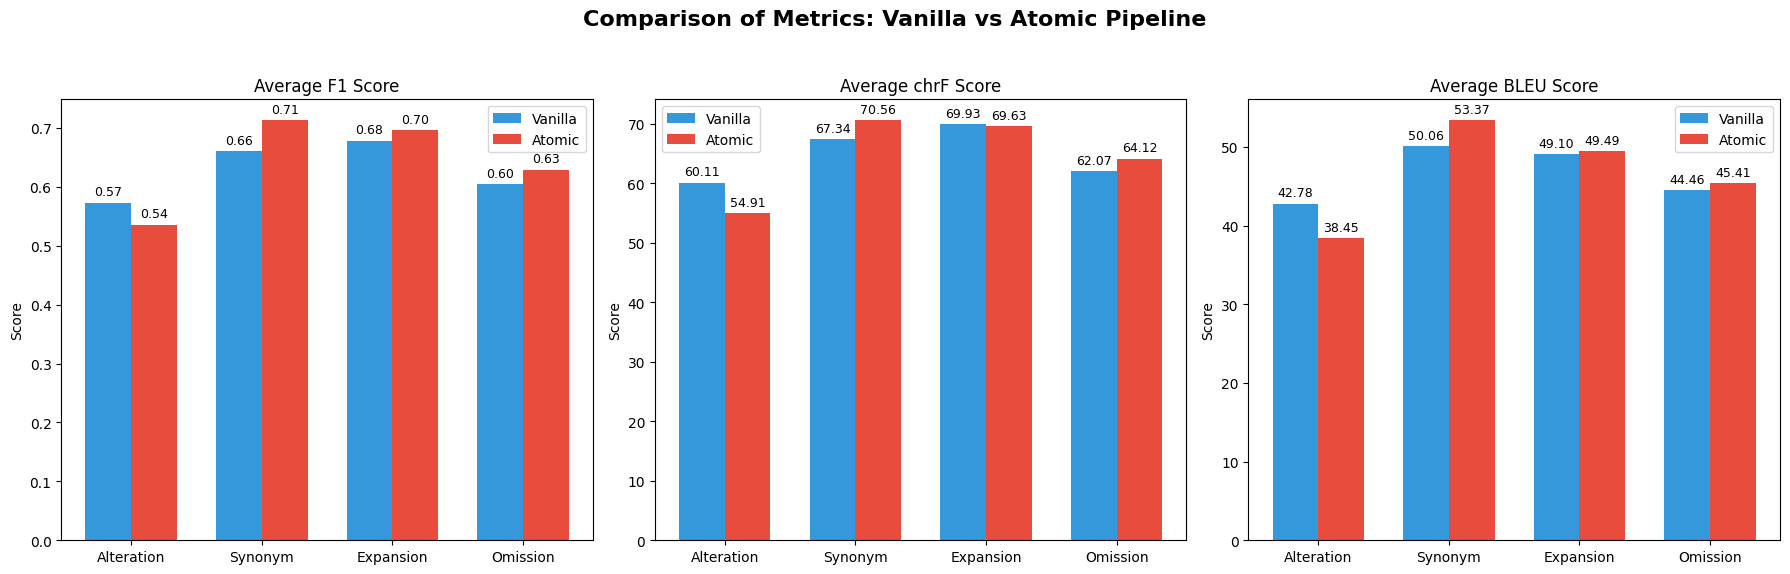

In [12]:
# Load data from string-comparison results
from pathlib import Path
import numpy as np
import pandas as pd

def load_string_comparison_data(pipeline, perturbation):
    """Load average scores from string-comparison JSONL files"""
    base_path = Path('/content/CucumBERT_askqe/evaluation/string-comparison/en-es')
    file_path = base_path / pipeline / f"{perturbation}.jsonl"

    scores = {'f1': [], 'chrf': [], 'bleu': []}

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                entry = json.loads(line)
                scores['f1'].append(entry['avg_f1'])
                scores['chrf'].append(entry['avg_chrf'])
                scores['bleu'].append(entry['avg_bleu'])

        # Calculate average across all entries
        avg_scores = {
            'f1': sum(scores['f1']) / len(scores['f1']) if scores['f1'] else 0,
            'chrf': sum(scores['chrf']) / len(scores['chrf']) if scores['chrf'] else 0,
            'bleu': sum(scores['bleu']) / len(scores['bleu']) if scores['bleu'] else 0
        }
        return avg_scores
    except FileNotFoundError:
        print(f"Warning: File not found - {file_path}")
        return {'f1': 0, 'chrf': 0, 'bleu': 0}

# Load data for all perturbations and pipelines
perturbations = ['alteration', 'synonym', 'expansion_noimpact', 'omission']
perturbation_labels = ['Alteration', 'Synonym', 'Expansion', 'Omission']

data = {'Perturbation': perturbation_labels}

for pipeline in ['vanilla', 'atomic']:
    f1_scores = []
    chrf_scores = []
    bleu_scores = []

    for pert in perturbations:
        scores = load_string_comparison_data(pipeline, pert)
        f1_scores.append(scores['f1'])
        chrf_scores.append(scores['chrf'])
        bleu_scores.append(scores['bleu'])

    data[f'{pipeline.capitalize()}_F1'] = f1_scores
    data[f'{pipeline.capitalize()}_chrF'] = chrf_scores
    data[f'{pipeline.capitalize()}_BLEU'] = bleu_scores

df = pd.DataFrame(data)

print("Loaded average scores from string-comparison data:")
print(df.to_string(index=False))

# Setting up the figure with 3 subplots for F1, chrF, and BLEU
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparison of Metrics: Vanilla vs Atomic Pipeline', fontsize=16, fontweight='bold')

metrics = ['F1', 'chrF', 'BLEU']
colors = ['#3498db', '#e74c3c'] # Blue for Vanilla, Red for Atomic

x = np.arange(len(df['Perturbation']))
width = 0.35

for i, metric in enumerate(metrics):
    vanilla_col = f'Vanilla_{metric}'
    atomic_col = f'Atomic_{metric}'

    rects1 = axes[i].bar(x - width/2, df[vanilla_col], width, label='Vanilla', color=colors[0])
    rects2 = axes[i].bar(x + width/2, df[atomic_col], width, label='Atomic', color=colors[1])

    axes[i].set_title(f'Average {metric} Score')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(df['Perturbation'])
    axes[i].set_ylabel('Score')
    axes[i].legend()

    # Add values on top of bars
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1, axes[i])
    autolabel(rects2, axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('vanilla_vs_atomic_metrics.png')
plt.show()

### 2.2 Pearson Correlation Analysis

The **Pearson correlation coefficient** (r) measures the linear relationship between AskQE metrics and standard MT metrics:

- **r > 0.7**: Strong positive correlation — metrics agree well
- **r = 0.4-0.7**: Moderate correlation — some agreement
- **r < 0.4**: Weak correlation — metrics measure different aspects

**Key Question**: Do AskQE metrics correlate with established MT quality metrics? If yes, AskQE captures similar quality dimensions.

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load Pearson correlation results
pearson_path = '/content/CucumBERT_askqe/evaluation/pearson-correlation/results_en-es.json'
with open(pearson_path, 'r') as f:
    pearson_data = json.load(f)

# Extract correlations into a dataframe for easier manipulation
correlations = pearson_data['correlations']
df_corr = pd.DataFrame(correlations)

# Filter to get only correlations with standard metrics
df_xcomet = df_corr[df_corr['standard_metric'] == 'xcomet'].copy()
df_bertscore = df_corr[df_corr['standard_metric'] == 'bt_score'].copy()

print("Sample Pearson Correlations:")
print(df_xcomet.head())
print(f"\nTotal correlations: {len(df_corr)}")


Sample Pearson Correlations:
   askqe_metric standard_metric  n_instances  pearson_r       p_value
0    f1-vanilla          xcomet         1968   0.252532  5.219605e-30
2     f1-atomic          xcomet         1910   0.240352  1.671745e-26
4    em-vanilla          xcomet         1968   0.134340  2.191022e-09
6     em-atomic          xcomet         1910   0.114929  4.747940e-07
8  bleu-vanilla          xcomet         1968   0.204447  5.147510e-20

Total correlations: 20


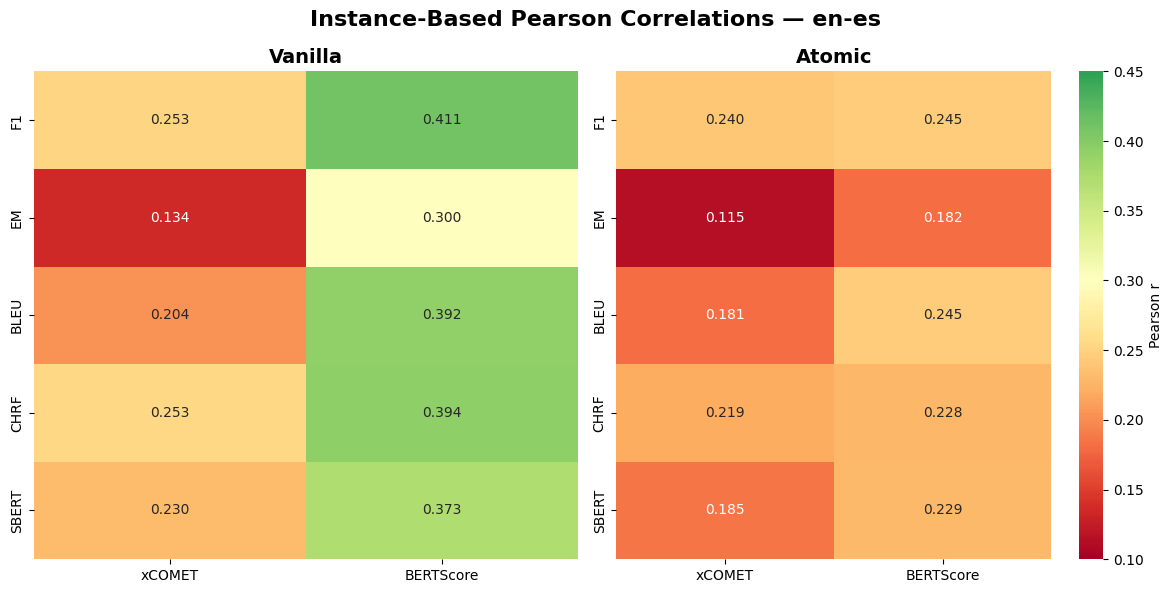

In [14]:
# Create side-by-side heatmaps for Vanilla and Atomic pipelines
import numpy as np

# Add pipeline column
df_corr['pipeline'] = df_corr['askqe_metric'].apply(lambda x: x.split('-')[1] if '-' in x else 'unknown')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Instance-Based Pearson Correlations — en-es', fontsize=16, fontweight='bold')

pipelines = ['vanilla', 'atomic']

for idx, pipeline in enumerate(pipelines):
    # Filter data for this pipeline
    df_pipeline = df_corr[df_corr['pipeline'] == pipeline].copy()

    # Extract metric base name (remove pipeline suffix)
    df_pipeline['metric_base'] = df_pipeline['askqe_metric'].str.replace(f'-{pipeline}', '')

    # Create pivot table
    corr_pivot = df_pipeline.pivot_table(
        index='metric_base',
        columns='standard_metric',
        values='pearson_r'
    )

    # Rename columns and reorder
    corr_pivot.columns = ['BERTScore', 'xCOMET']
    corr_pivot = corr_pivot[['xCOMET', 'BERTScore']]  # xCOMET first

    # Reorder rows in specified order
    metric_order = ['f1', 'em', 'bleu', 'chrf', 'sbert']
    corr_pivot = corr_pivot.reindex([m for m in metric_order if m in corr_pivot.index])

    # Uppercase row labels
    corr_pivot.index = [m.upper() for m in corr_pivot.index]

    # Create heatmap
    sns.heatmap(corr_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                center=0.3, cbar=(idx == 1),  # Only rightmost has colorbar
                cbar_kws={'label': 'Pearson r'} if idx == 1 else {},
                ax=axes[idx], vmin=0.1, vmax=0.45)

    axes[idx].set_title(pipeline.capitalize(), fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('', fontsize=11) if idx == 1 else axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()


### 2.3 Silhouette Score Analysis

The **Silhouette score** measures how well a metric separates critical perturbations from minimal ones:

- **Score = 1**: Perfect separation — metric clearly distinguishes error types
- **Score = 0**: No separation — metric cannot differentiate quality levels
- **Score = -1**: Inverted clusters — metric behaves opposite to expected

**Interpretation**:
- **High silhouette** → Metric is sensitive to quality degradation
- **Low silhouette** → Metric cannot reliably detect translation errors

**Key Question**: Can AskQE metrics distinguish between critical and minimal perturbations? This tests the metric's discriminative power in the legal domain.

In [15]:
# Load Silhouette results
silhouette_path = '/content/CucumBERT_askqe/evaluation/silhouette/results_en-es.json'
with open(silhouette_path, 'r') as f:
    silhouette_data = json.load(f)

# Parse silhouette results
sil_results = []
for result in silhouette_data['results']:
    pipeline = result['pipeline']
    for metric, values in result['metrics'].items():
        sil_results.append({
            'pipeline': pipeline,
            'metric': metric,
            'silhouette_score': values['silhouette_score'],
            'n_samples': values['n_samples']
        })

# Add MT metrics
for metric, values in silhouette_data['mt_results'].items():
    sil_results.append({
        'pipeline': 'mt',
        'metric': metric,
        'silhouette_score': values['silhouette_score'],
        'n_samples': values['n_samples']
    })

df_sil = pd.DataFrame(sil_results)

print("Silhouette Score Data:")
print(df_sil.to_string())
print(f"\nCritical perturbations: {silhouette_data['critical_perturbations']}")
print(f"Minimal perturbations: {silhouette_data['minimal_perturbations']}")


Silhouette Score Data:
   pipeline     metric  silhouette_score  n_samples
0   vanilla      sbert          0.028441       1968
1   vanilla         f1          0.027491       1968
2   vanilla         em          0.003856       1968
3   vanilla       chrf          0.028476       1968
4   vanilla       bleu          0.011586       1968
5    atomic      sbert          0.025770       1910
6    atomic         f1          0.039664       1910
7    atomic         em          0.007484       1910
8    atomic       chrf          0.032835       1910
9    atomic       bleu          0.017670       1910
10       mt     xcomet          0.286540       2000
11       mt  bertscore          0.056288       2000

Critical perturbations: ['omission', 'alteration']
Minimal perturbations: ['synonym', 'expansion_noimpact']


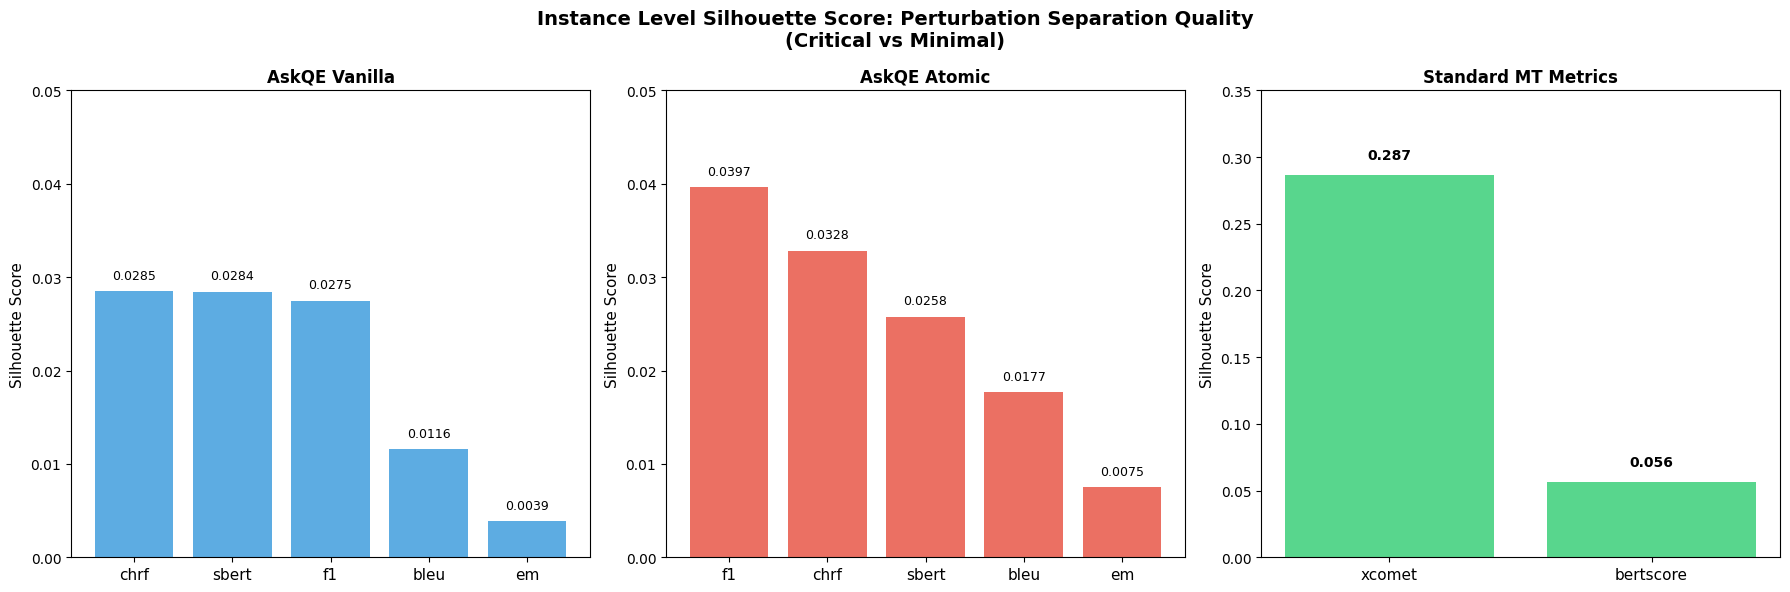

In [16]:
# Visualization 1: Silhouette comparison across metrics and pipelines
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Instance Level Silhouette Score: Perturbation Separation Quality\n(Critical vs Minimal)',
             fontsize=14, fontweight='bold')

# AskQE Vanilla metrics
vanilla_data = df_sil[df_sil['pipeline'] == 'vanilla'].copy()
vanilla_data = vanilla_data.sort_values('silhouette_score', ascending=False)

axes[0].bar(range(len(vanilla_data)), vanilla_data['silhouette_score'], color='#3498db', alpha=0.8)
axes[0].set_xticks(range(len(vanilla_data)))
axes[0].set_xticklabels(vanilla_data['metric'], fontsize=11)
axes[0].set_ylabel('Silhouette Score', fontsize=11)
axes[0].set_title('AskQE Vanilla', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 0.05)

# Add value labels
for i, (idx, row) in enumerate(vanilla_data.iterrows()):
    axes[0].text(i, row['silhouette_score'] + 0.001, f"{row['silhouette_score']:.4f}",
                ha='center', va='bottom', fontsize=9)

# AskQE Atomic metrics
atomic_data = df_sil[df_sil['pipeline'] == 'atomic'].copy()
atomic_data = atomic_data.sort_values('silhouette_score', ascending=False)

axes[1].bar(range(len(atomic_data)), atomic_data['silhouette_score'], color='#e74c3c', alpha=0.8)
axes[1].set_xticks(range(len(atomic_data)))
axes[1].set_xticklabels(atomic_data['metric'], fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('AskQE Atomic', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 0.05)

# Add value labels
for i, (idx, row) in enumerate(atomic_data.iterrows()):
    axes[1].text(i, row['silhouette_score'] + 0.001, f"{row['silhouette_score']:.4f}",
                ha='center', va='bottom', fontsize=9)

# MT metrics
mt_data = df_sil[df_sil['pipeline'] == 'mt'].copy()
mt_data = mt_data.sort_values('silhouette_score', ascending=False)

axes[2].bar(range(len(mt_data)), mt_data['silhouette_score'], color='#2ecc71', alpha=0.8)
axes[2].set_xticks(range(len(mt_data)))
axes[2].set_xticklabels(mt_data['metric'], fontsize=11)
axes[2].set_ylabel('Silhouette Score', fontsize=11)
axes[2].set_title('Standard MT Metrics', fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 0.35)

# Add value labels
for i, (idx, row) in enumerate(mt_data.iterrows()):
    axes[2].text(i, row['silhouette_score'] + 0.01, f"{row['silhouette_score']:.3f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## Key Takeaways

### Domain Adaptation Challenges

1. **Legal domain characteristics**:
   - High lexical overlap between translations
   - Rigid, technical terminology
   - Complex conditional structures
   - Less paraphrasing variability than medical/general domains

2. **AskQE Performance**:
   - **Low silhouette scores (~0.02)**: Poor separation between error types
   - **Moderate Pearson correlation (0.25-0.41)**: Some alignment with MT metrics
   - **Pipeline variation**: Vanilla and Atomic show different correlation patterns

3. **Comparison with MT Metrics**:
   - **xCOMET**: Excellent separation (0.287) — works well in legal domain
   - **BERTScore**: Weak separation (0.056) — struggles with legal texts
   - MT metrics outperform AskQE in discriminating quality levels

### Implications

- **Domain specificity matters**: AskQE's effectiveness varies significantly across domains
- **Question-based evaluation limitations**: In legal texts, QA may not capture nuanced translation errors
- **Need for domain adaptation**: AskQE requires refinement for technical/legal content